## FBRef - Progressive Passing for Top 5 Leagues

Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fbref_player_stats(url):
    
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import re
    
    response = requests.get(url)
    print(response)
    
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", response.text), 'lxml')
    
    player_table = soup.find_all('table')[1]
    
    player_df = pd.read_html(str(player_table))[0]
    
    level_one = player_df.columns.get_level_values(0).astype(str)
    level_two = player_df.columns.get_level_values(1).astype(str)
    new_columns = level_one + "|" + level_two
    new_columns = [x.split("|")[1] if x[0:7] == 'Unnamed' else x for x in new_columns]
    new_columns
    player_df.columns = new_columns
    
    drop_indices = player_df[player_df['Player'] == 'Player'].index
    player_df.drop(drop_indices, inplace = True)
    
    return player_df

Access data and convert columns to numeric.

In [3]:
passing = fbref_player_stats("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats")
num_columns = ['Age','90s',
               'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|TotDist', 'Total|PrgDist', 
               'Short|Cmp', 'Short|Att', 'Short|Cmp%', 
               'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 
               'Long|Cmp', 'Long|Att', 'Long|Cmp%', 
               'Ast', 'xA', 'A-xA', 'KP', 
               '1/3', 'PPA', 'CrsPA', 'Prog']
passing[num_columns] = passing[num_columns].apply(pd.to_numeric)
passing.drop('Matches', axis=1, inplace=True)
passing.head()

<Response [200]>


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Total|Cmp,...,Long|Att,Long|Cmp%,Ast,xA,A-xA,KP,1/3,PPA,CrsPA,Prog
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,28.0,1990,21.0,934.0,...,263.0,59.3,0,1.8,-1.8,24.0,67.0,20.0,4.0,158.0
1,2,Max Aarons,eng ENG,DF,Norwich City,eng Premier League,19.0,2000,27.0,1005.0,...,203.0,51.7,1,3.5,-2.5,20.0,36.0,26.0,11.0,105.0
2,3,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,31.0,1987,28.0,1328.0,...,568.0,82.4,0,0.2,-0.2,2.0,45.0,3.0,0.0,83.0
3,4,Suleiman Abdullahi,ng NGA,"FW,MF",Union Berlin,de Bundesliga,22.0,1996,1.1,11.0,...,3.0,33.3,0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
4,5,Mehdi Abeid,dz ALG,MF,Nantes,fr Ligue 1,26.0,1992,20.2,801.0,...,250.0,65.2,2,1.4,0.6,26.0,85.0,6.0,4.0,82.0


### Filter Passing

Define function to filter the fbref data by various fields

In [4]:
def player_filter_fbref(dataframe, 
                        mins_filter = 10, 
                        age_min = 0, 
                        age_max = 35, 
                        position_filter = [], 
                        nation_filter = [], 
                        squad_filter = [], 
                        comp_filter = []):
    
    filtered_df = dataframe.copy()
    
    if len(str(mins_filter)) > 0:
        filtered_df = filtered_df[filtered_df['90s'] > mins_filter]
    if len(str(age_min)) > 0:
        filtered_df = filtered_df[filtered_df['Age'] > age_min]
    if len(str(age_max)) > 0:
        filtered_df = filtered_df[filtered_df['Age'] < age_max]
    if len(position_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Pos'].isin(position_filter))]
    if len(nation_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Nation'].isin(nation_filter))]
    if len(squad_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Squad'].isin(squad_filter))]
    if len(comp_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Comp'].isin(comp_filter))]
        
    return filtered_df

In [5]:
passing_filtered = player_filter_fbref(passing,
                                       mins_filter = 20,
                                       age_min = 0,
                                       age_max = 23,
                                       position_filter = [],
                                       nation_filter = [],
                                       squad_filter = [],
                                       comp_filter = [])

### Passing per 90s

In [6]:
pass_cols =  ['Total|Cmp', 'Total|Att', 'Total|Cmp%', 
                'Total|TotDist', 'Total|PrgDist', 
                'Short|Cmp', 'Short|Att', 'Short|Cmp%', 
                'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 
                'Long|Cmp', 'Long|Att', 'Long|Cmp%', 
                'Ast', 'xA', 'A-xA', 'KP', 
                '1/3', 'PPA', 'CrsPA', 'Prog']

for col in pass_cols:
    passing_filtered[col + '|90'] = passing_filtered[col] / passing_filtered['90s']

passing_filtered.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Total|Cmp,...,Long|Att|90,Long|Cmp%|90,Ast|90,xA|90,A-xA|90,KP|90,1/3|90,PPA|90,CrsPA|90,Prog|90
1,2,Max Aarons,eng ENG,DF,Norwich City,eng Premier League,19.0,2000,27.0,1005.0,...,7.518519,1.914815,0.037037,0.129630,-0.092593,0.740741,1.333333,0.962963,0.407407,3.888889
7,8,Tammy Abraham,eng ENG,FW,Chelsea,eng Premier League,21.0,1997,21.5,250.0,...,2.139535,3.437209,0.139535,0.106977,0.032558,0.790698,0.744186,0.232558,0.000000,1.488372
60,59,Trent Alexander-Arnold,eng ENG,DF,Liverpool,eng Premier League,20.0,1998,28.3,1803.0,...,33.851590,1.908127,0.424028,0.303887,0.120141,2.579505,5.512367,2.402827,0.777385,12.862191
85,83,Sofyan Amrabat,ma MAR,MF,Hellas Verona,it Serie A,22.0,1996,21.6,941.0,...,14.814815,3.893519,0.000000,0.055556,-0.055556,0.833333,3.657407,1.018519,0.370370,4.398148
109,106,Houssem Aouar,fr FRA,MF,Lyon,fr Ligue 1,21.0,1998,21.7,911.0,...,9.861751,3.488479,0.184332,0.142857,0.041475,1.244240,4.976959,1.059908,0.000000,5.115207


### Normalised Passing

In [7]:
pass_cols =  [
    'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|Cmp|90', 'Total|Att|90', 'Total|Cmp%|90',
    'Total|TotDist', 'Total|PrgDist', 'Total|TotDist|90', 'Total|PrgDist|90', 
    'Short|Cmp', 'Short|Att', 'Short|Cmp%', 'Short|Cmp|90', 'Short|Att|90', 'Short|Cmp%|90', 
    'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 'Medium|Cmp|90','Medium|Att|90', 'Medium|Cmp%|90', 
    'Long|Cmp', 'Long|Att', 'Long|Cmp%', 'Long|Cmp|90', 'Long|Att|90', 'Long|Cmp%|90', 
    'Ast', 'xA', 'A-xA', 'KP', 'Ast|90', 'xA|90', 'A-xA|90', 'KP|90', 
    '1/3', 'PPA', 'CrsPA', 'Prog', '1/3|90', 'PPA|90', 'CrsPA|90', 'Prog|90',
]

for col in pass_cols:
    max_col = passing_filtered[col].max()
    min_col = passing_filtered[col].min()
    scale_col = (passing_filtered[col] - min_col) / (max_col - min_col)
    passing_filtered[col + '|N'] = scale_col

passing_filtered.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Total|Cmp,...,A-xA|90|N,KP|90|N,1/3|N,PPA|N,CrsPA|N,Prog|N,1/3|90|N,PPA|90|N,CrsPA|90|N,Prog|90|N
1,2,Max Aarons,eng ENG,DF,Norwich City,eng Premier League,19.0,2000,27.0,1005.0,...,0.110326,0.232172,0.191860,0.371429,0.366667,0.288462,0.173611,0.331534,0.369383,0.302350
7,8,Tammy Abraham,eng ENG,FW,Chelsea,eng Premier League,21.0,1997,21.5,250.0,...,0.410590,0.247831,0.075581,0.071429,0.000000,0.087912,0.087694,0.080066,0.000000,0.115717
60,59,Trent Alexander-Arnold,eng ENG,DF,Liverpool,eng Premier League,20.0,1998,28.3,1803.0,...,0.620721,0.808502,0.889535,0.971429,0.733333,1.000000,0.783054,0.827259,0.704829,1.000000
85,83,Sofyan Amrabat,ma MAR,MF,Hellas Verona,it Serie A,22.0,1996,21.6,941.0,...,0.199186,0.261194,0.441860,0.314286,0.266667,0.260989,0.512539,0.350661,0.335802,0.341944
109,106,Houssem Aouar,fr FRA,MF,Lyon,fr Ligue 1,21.0,1998,21.7,911.0,...,0.431983,0.389986,0.610465,0.328571,0.000000,0.304945,0.704973,0.364911,0.000000,0.397693


## Exploration

Convert from wide to long data to create Swarm Plots

In [8]:
value_cols = [
        'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|TotDist',
        'Total|PrgDist', 'Short|Cmp', 'Short|Att', 'Short|Cmp%', 'Medium|Cmp',
        'Medium|Att', 'Medium|Cmp%', 'Long|Cmp', 'Long|Att', 'Long|Cmp%', 'Ast',
        'xA', 'A-xA', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog',
        'Total|Cmp|90', 'Total|Att|90', 'Total|Cmp%|90', 'Total|TotDist|90',
        'Total|PrgDist|90', 'Short|Cmp|90', 'Short|Att|90', 'Short|Cmp%|90',
        'Medium|Cmp|90', 'Medium|Att|90', 'Medium|Cmp%|90', 'Long|Cmp|90',
        'Long|Att|90', 'Long|Cmp%|90', 'Ast|90', 'xA|90', 'A-xA|90', 'KP|90',
        '1/3|90', 'PPA|90', 'CrsPA|90', 'Prog|90', 'Total|Cmp|N', 'Total|Att|N',
        'Total|Cmp%|N', 'Total|Cmp|90|N', 'Total|Att|90|N', 'Total|Cmp%|90|N',
        'Total|TotDist|N', 'Total|PrgDist|N', 'Total|TotDist|90|N',
        'Total|PrgDist|90|N', 'Short|Cmp|N', 'Short|Att|N', 'Short|Cmp%|N',
        'Short|Cmp|90|N', 'Short|Att|90|N', 'Short|Cmp%|90|N', 'Medium|Cmp|N',
        'Medium|Att|N', 'Medium|Cmp%|N', 'Medium|Cmp|90|N', 'Medium|Att|90|N',
        'Medium|Cmp%|90|N', 'Long|Cmp|N', 'Long|Att|N', 'Long|Cmp%|N',
        'Long|Cmp|90|N', 'Long|Att|90|N', 'Long|Cmp%|90|N', 'Ast|N', 'xA|N',
        'A-xA|N', 'KP|N', 'Ast|90|N', 'xA|90|N', 'A-xA|90|N', 'KP|90|N',
        '1/3|N', 'PPA|N', 'CrsPA|N', 'Prog|N', '1/3|90|N', 'PPA|90|N',
        'CrsPA|90|N', 'Prog|90|N']

passing_long = pd.melt(passing_filtered,
                       id_vars=['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp'],
                       value_vars=value_cols)
passing_long['value'] = passing_long['value'].apply(pd.to_numeric)


### Filtered Swarm Plots

Define function to create swarm plots for specified columns

In [9]:
def passing_swarm(dataframe, columns = []):

    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]
    
    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')
    plt.figure(figsize=(15,7.5))
    g1 = sns.swarmplot(x="value", y="variable", data=dataframe,
                      palette='pastel',
                      alpha = 0.5)

    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle('Title Placeholder',
                 fontproperties = font, x = 0.2, y = 0.95)
    plt.title('Progressive Passing Percentiles',
              fontproperties = font, size=10, loc='left')
    plt.show()

#### Passing per 90s

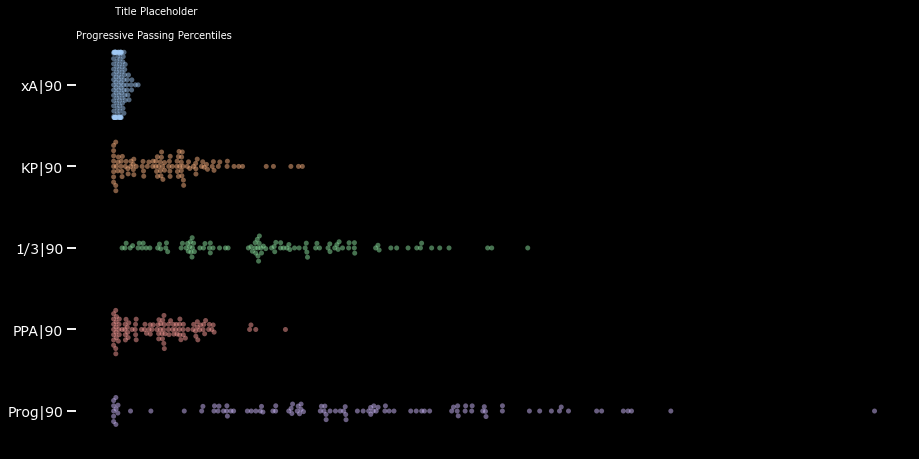

In [10]:
passing_swarm(passing_long, columns=['Prog|90', 'KP|90', '1/3|90', 'PPA|90', 'xA|90'])

#### Passing Normalised

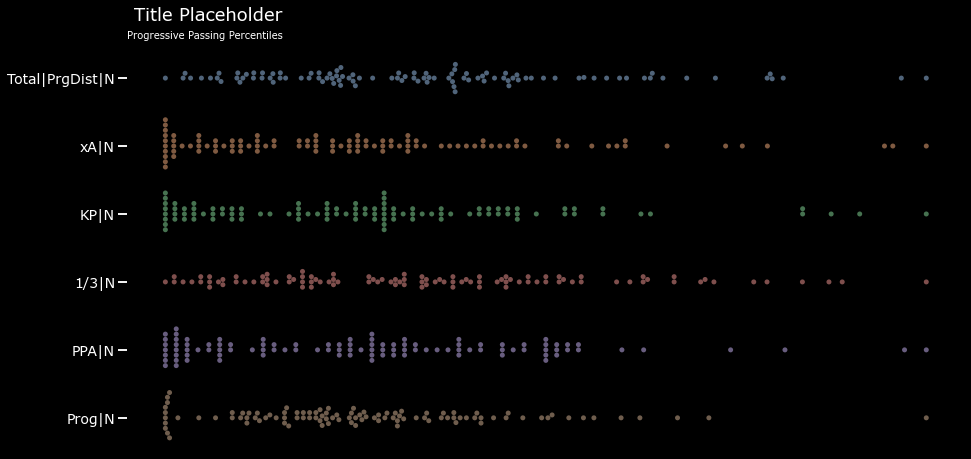

In [11]:
passing_swarm(passing_long, columns=['Total|PrgDist|N', 'Prog|N', 'KP|N', '1/3|N', 'PPA|N', 'xA|N'])

#### Passing per 90s + Normalised

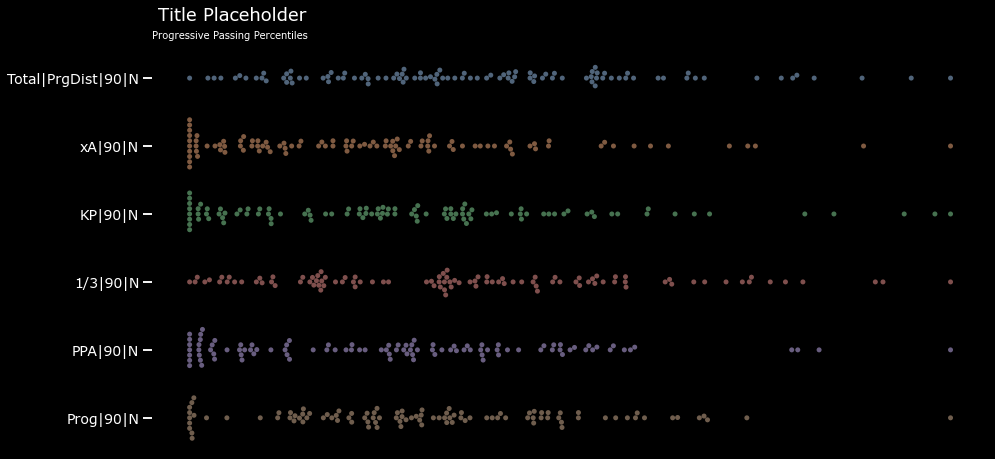

In [12]:
passing_swarm(passing_long, columns=['Total|PrgDist|90|N', 'Prog|90|N', 'KP|90|N', '1/3|90|N', 'PPA|90|N', 'xA|90|N'])

### Player Swarm Plots

Define swarm plots for specific players and team colours

In [13]:
def passing_swarm_player(dataframe, selected_player, columns = [], team_primary_colour='w', team_secondary_colour='w', title_ha = 0.2):

    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]
        
    dataframe_player = dataframe[dataframe['Player'] == selected_player]

    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')
    plt.figure(figsize=(15,7.5))
    g1 = sns.swarmplot(x="value", y="variable", data=dataframe,
                       order = columns,
                       palette='pastel',
                       alpha = 0.2)
    g2 = sns.swarmplot(x="value", y="variable", data=dataframe_player,
                       order = columns,
                       alpha = 0.9, size = 10, 
                       color=team_primary_colour, edgecolor = team_secondary_colour, linewidth=1)


    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle(selected_player,
                 fontproperties = font, x = title_ha, y = 0.95)
    plt.title('Title Placeholder',
              fontproperties = font, size=10, loc='left')
    plt.show()

#### u23 Players (20+ 90s)

Top performers across normalised per 90 minutes:

In [14]:
columns=['Total|PrgDist|90|N', 'Prog|90|N', 'KP|90|N', '1/3|90|N', 'PPA|90|N', 'xA|90|N']
passing_long[passing_long['variable'].isin(columns) & 
             (passing_long['Pos'] != 'GK') &
             (passing_long['value'] > 0.8)].sort_values('value', ascending=False)

,Rk,Player,Nation,Pos,Squad,Comp,variable,value
8002,1716,Christopher Nkunku,fr FRA,"MF,FW",RB Leipzig,de Bundesliga,xA|90|N,1.000000
8208,1716,Christopher Nkunku,fr FRA,"MF,FW",RB Leipzig,de Bundesliga,KP|90|N,1.000000
8735,2022,Marc Roca,es ESP,MF,Espanyol,es La Liga,1/3|90|N,1.000000
8857,2595,Martin Ødegaard,no NOR,MF,Real Sociedad,es La Liga,PPA|90|N,1.000000
8963,59,Trent Alexander-Arnold,eng ENG,DF,Liverpool,eng Premier League,Prog|90|N,1.000000
8149,370,Emi Buendía,ar ARG,"FW,MF",Norwich City,eng Premier League,KP|90|N,0.979478
5461,59,Trent Alexander-Arnold,eng ENG,DF,Liverpool,eng Premier League,Total|PrgDist|90|N,0.948360
8196,1425,James Maddison,eng ENG,MF,Leicester City,eng Premier League,KP|90|N,0.939125
8697,1151,Frenkie de Jong,nl NED,MF,Barcelona,es La Liga,1/3|90|N,0.911232
8748,2428,Dayot Upamecano,fr FRA,DF,RB Leipzig,de Bundesliga,1/3|90|N,0.901171


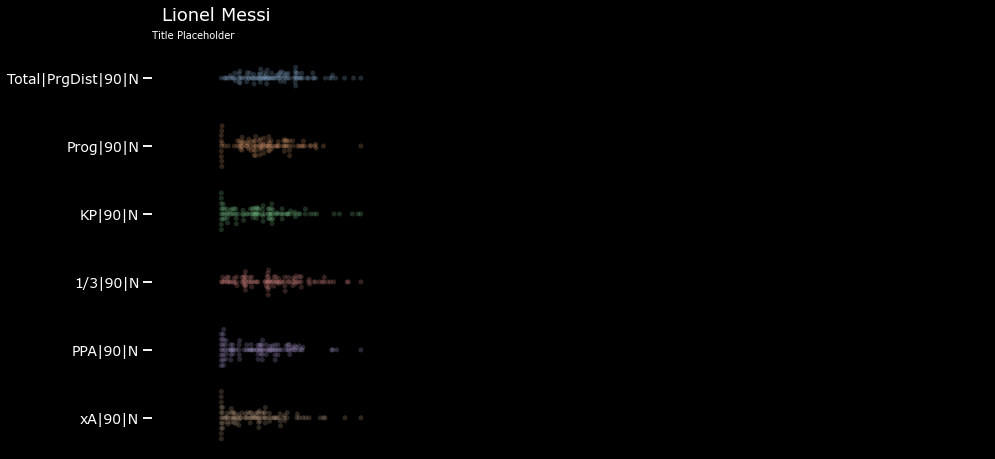

In [15]:
passing_swarm_player(passing_long, 'Lionel Messi', columns=columns, team_primary_colour='r', team_secondary_colour='b', title_ha=0.185)

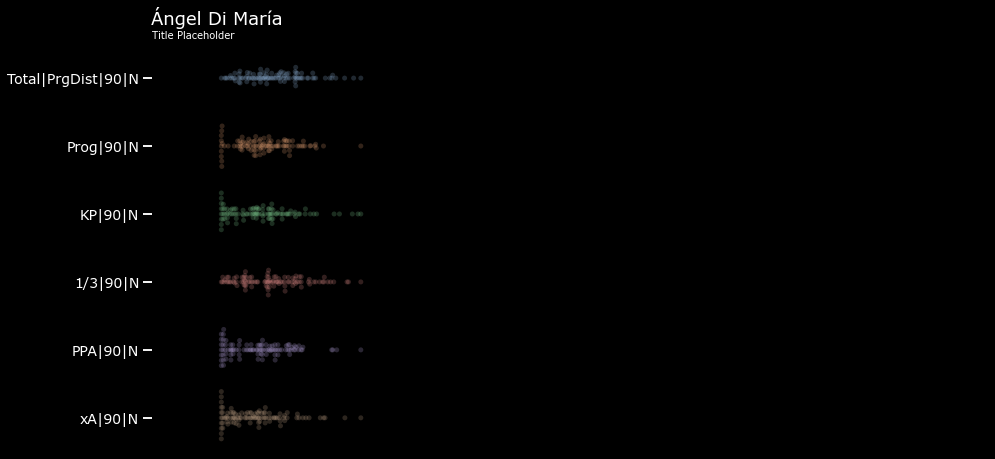

In [16]:
passing_swarm_player(passing_long, 'Ángel Di María', columns=columns, team_primary_colour='b', team_secondary_colour='r', title_ha=0.185)

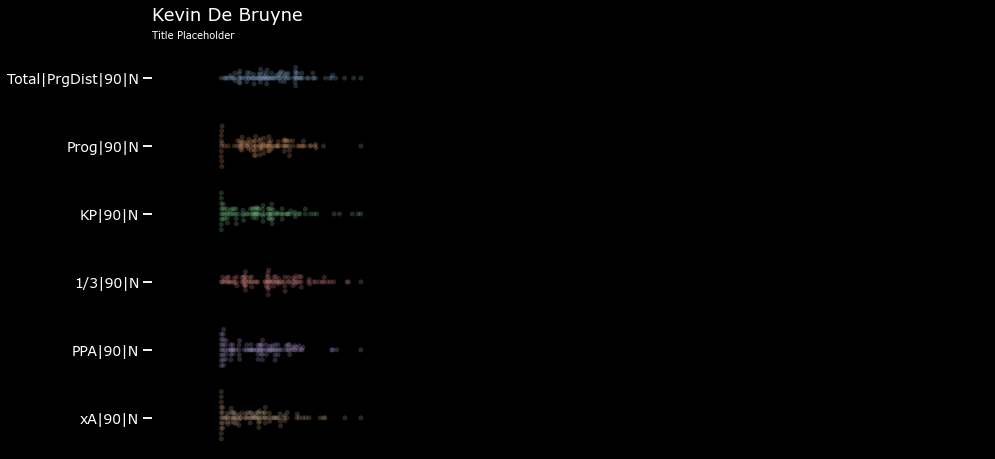

In [17]:
passing_swarm_player(passing_long, 'Kevin De Bruyne', columns=columns, team_primary_colour='skyblue', team_secondary_colour='w', title_ha=0.195)

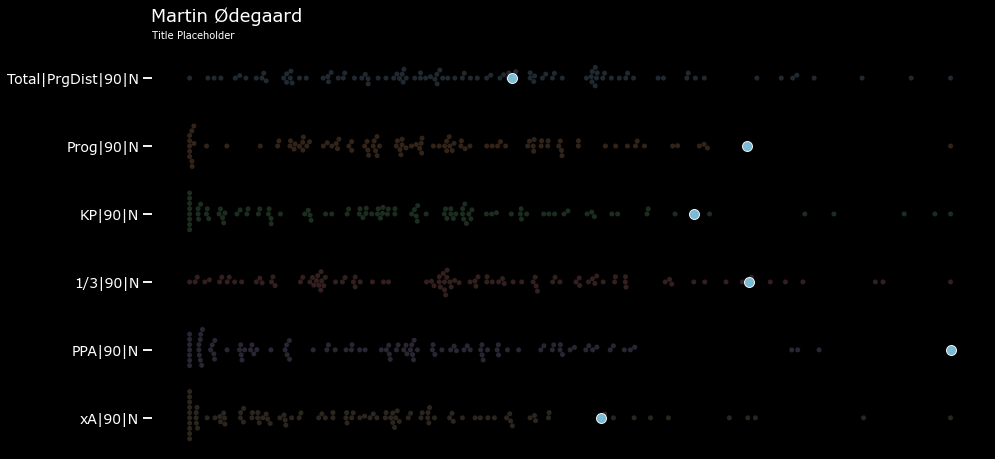

In [18]:
passing_swarm_player(passing_long, 'Martin Ødegaard', columns=columns, team_primary_colour='skyblue', team_secondary_colour='w', title_ha=0.195)

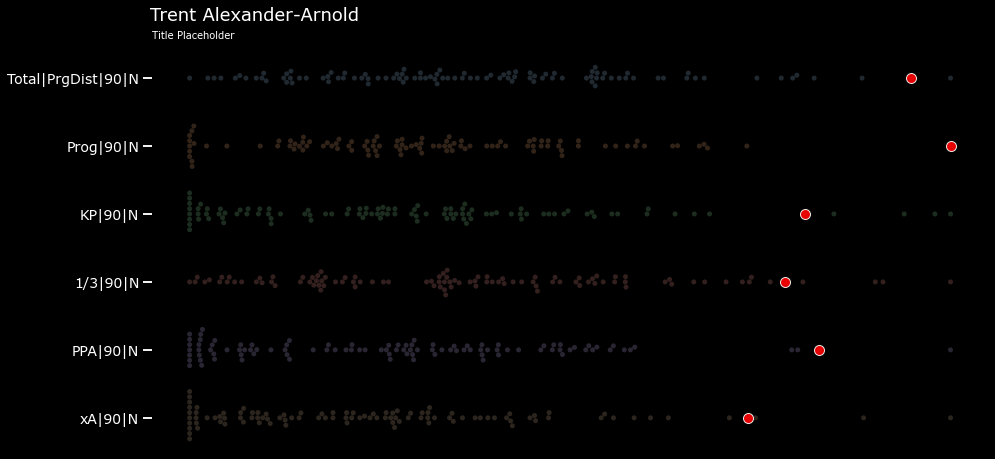

In [19]:
passing_swarm_player(passing_long, 'Trent Alexander-Arnold', columns=columns, team_primary_colour='r', team_secondary_colour='w', title_ha=0.22)

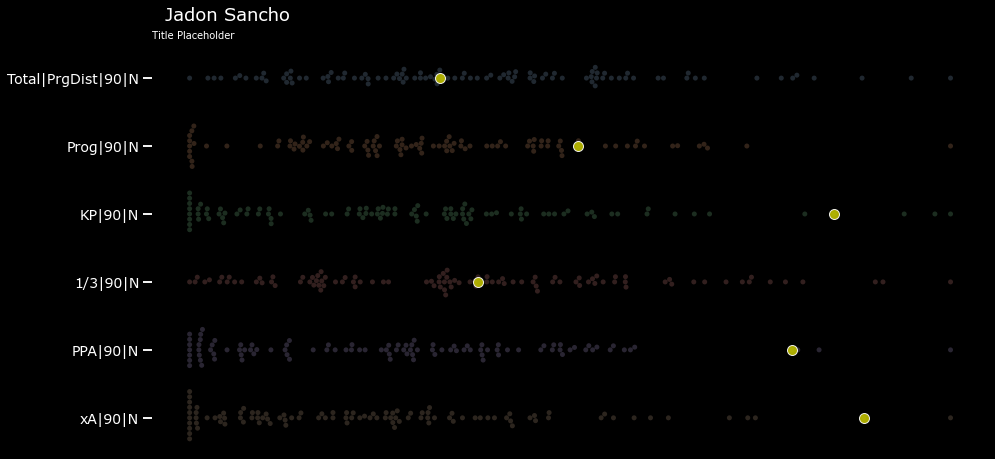

In [20]:
passing_swarm_player(passing_long, 'Jadon Sancho', columns=columns, team_primary_colour='y', team_secondary_colour='w', title_ha=0.195)

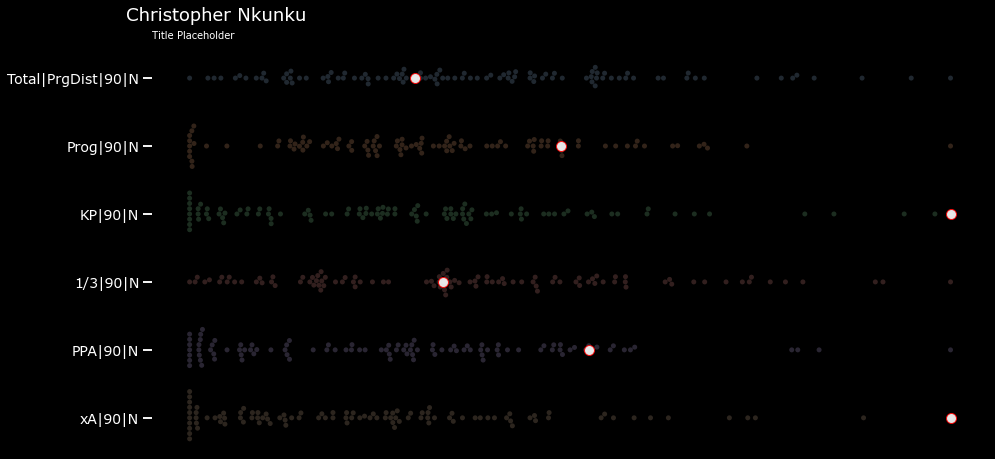

In [21]:
passing_swarm_player(passing_long, 'Christopher Nkunku', columns=columns, team_primary_colour='w', team_secondary_colour='r', title_ha=0.185)

## Custom Plots

### u23 Leaders

Define function to include images to plots and add custom title

In [22]:
def custom_image_player_swarms(dataframe,
                               selected_player,
                               image_path,
                               columns,
                               title = 'Placeholder',
                               title_ha = 0.17
                              ):
    # Keep only relevant columns
    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]

    # Keep only specified player
    dataframe_player = dataframe[dataframe['Player'] == selected_player]
    dataframe_player = dataframe_player.set_index('variable').reindex(columns).reset_index()

    # Set plot themes
    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')

    # Set up figure
    plt.figure(figsize=(15,7.5))
    
    # Plot swarm for all
    swarm = sns.swarmplot(x="value", y="variable", data=dataframe,
                          order = columns,
                          palette='pastel',
                          alpha = 0.2)
    
    # Plot custom image for player
    player = sns.scatterplot(x="value", y="variable", data=dataframe_player)
    image = OffsetImage(plt.imread(image_path, 0), zoom=0.2)
    x = dataframe_player['value']
    y = dataframe_player['variable']
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(image, (x0, y0), frameon=False)
        player.add_artist(ab)

    # Set plot labels and titles
    plt.xlabel('')
    plt.xticks([0, 0.5, 1], size = 11)
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle(title, fontproperties = font, size = 18 , x = 0.125, y = 0.99, ha='left')
    plt.title('2019/20 - Progressive Passes from fbref.com - Normalised and per 90 mins - @TLMAnalytics',
              fontproperties = font, size=10, loc='left')

    plt.show()

#### Trent Alexander-Arnold

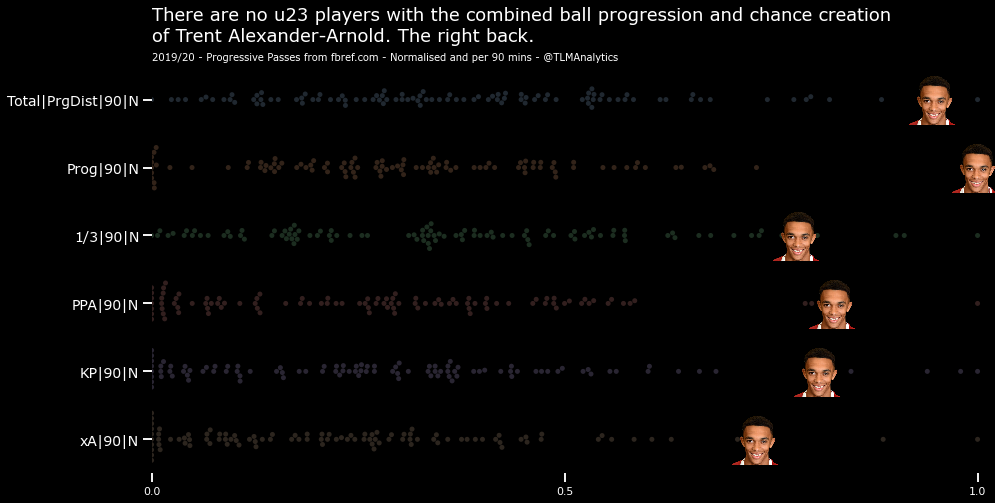

In [27]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Trent Alexander-Arnold',
                           image_path = "taa.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'There are no u23 players with the combined ball progression and chance creation\nof Trent Alexander-Arnold. The right back.',
                           title_ha = 0.17
                           )

#### Martin Odegaard

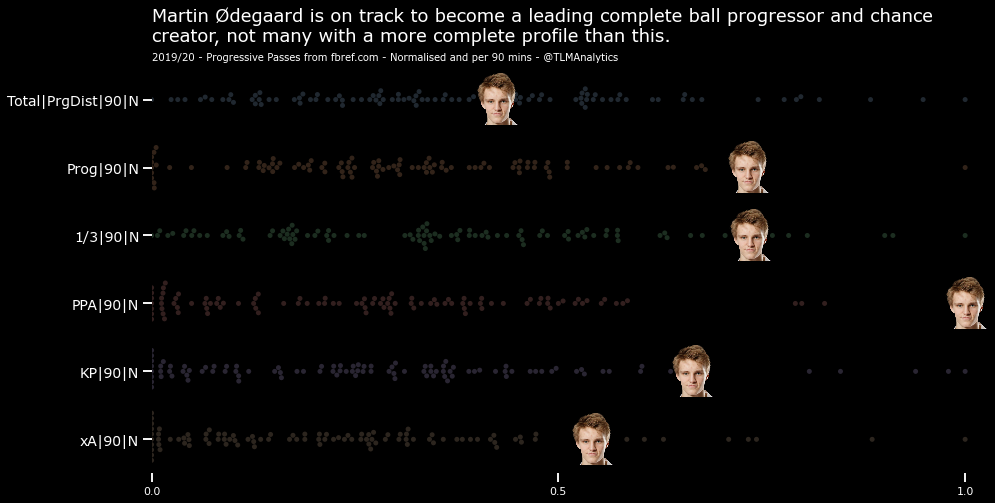

In [28]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Martin Ødegaard',
                           image_path = "odegaard.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'Martin Ødegaard is on track to become a leading complete ball progressor and chance\ncreator, not many with a more complete profile than this.',
                           title_ha = 0.17
                           )

#### Jadon Sancho

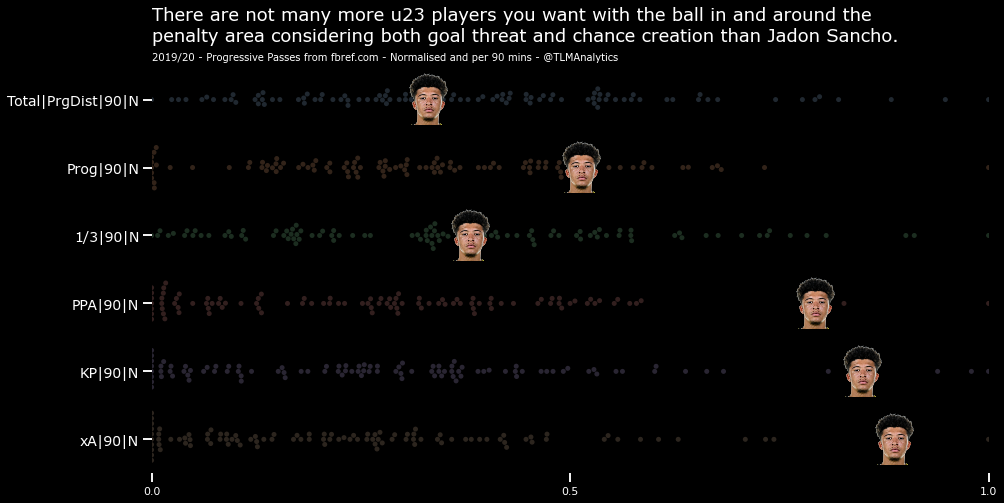

In [29]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Jadon Sancho',
                           image_path = "sancho.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'There are not many more u23 players you want with the ball in and around the\npenalty area considering both goal threat and chance creation than Jadon Sancho.',
                           title_ha = 0.17
                           )

#### Christopher Nkunku

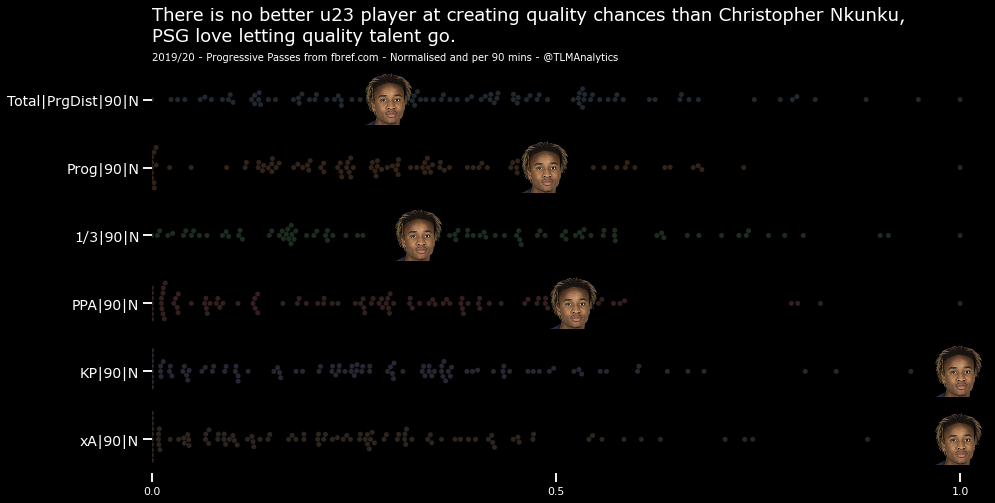

In [30]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Christopher Nkunku',
                           image_path = "nkunku.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'There is no better u23 player at creating quality chances than Christopher Nkunku,\nPSG love letting quality talent go.',
                           title_ha = 0.17
                           )